In [1]:
print("hello mother")

hello mother


In [3]:
from PIL import Image
import numpy as np

def convert_to_grayscale_and_resize(image_path, new_size=(625, 100)):
    with Image.open(image_path) as img:

        # Convert the image to grayscale
        img_gray = img.convert("L")
        img_resized = img_gray.resize(new_size, Image.Resampling.LANCZOS)
        image_array = np.array(img_resized)

        return image_array


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


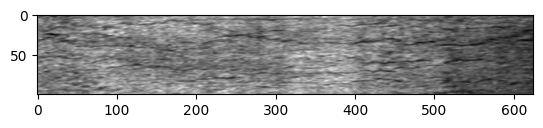

In [5]:
from matplotlib import pyplot
img = convert_to_grayscale_and_resize("/content/drive/MyDrive/Colab Notebooks/yolo-dataset/train_images/crazing_100.jpg", new_size=(625, 100))
pyplot.imshow(img, cmap=pyplot.get_cmap('gray'))


<ipython-input-6-ea52327c21be>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette='viridis')
<ipython-input-6-ea52327c21be>:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


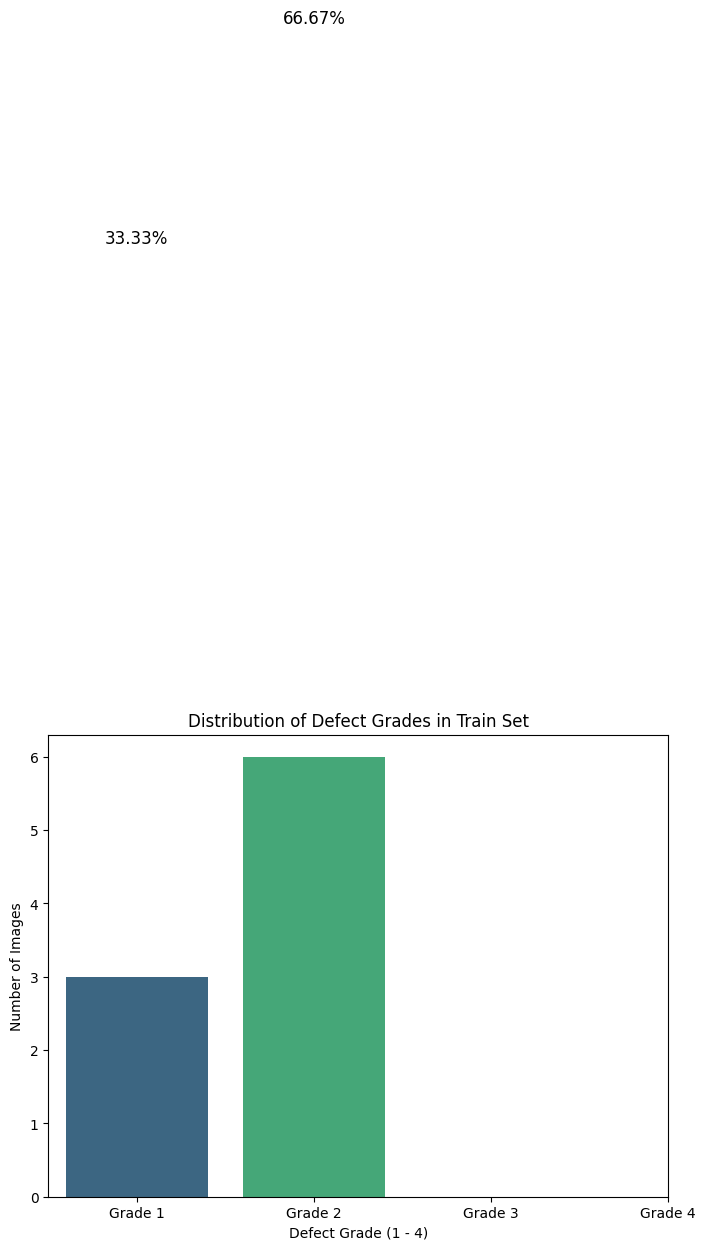

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


CSV_PATH = "/content/train.csv"
data = pd.read_csv(CSV_PATH)

# Rename columns for clarity
data = data.rename(columns={'ImageId': 'image_name', 'ClassId': 'grade'})
train_y = data['grade'].astype(int)

# Calculate the percentage of each grade in train_y
unique, counts = np.unique(train_y, return_counts=True)
percentages = (counts / len(train_y)) * 100

# Create a plot to visualize the distribution of train_y values
plt.figure(figsize=(8, 6))

# Plot the distribution of grades
sns.barplot(x=unique, y=counts, palette='viridis')

# Add labels and title
plt.title('Distribution of Defect Grades in Train Set')
plt.xlabel('Defect Grade (1 - 4)')
plt.ylabel('Number of Images')
plt.xticks([0, 1, 2, 3], ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4'])

# Annotate each bar with the percentage
for i in range(len(unique)):
    plt.text(i, counts[i] + 10, f'{percentages[i]:.2f}%', ha='center', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Load and preprocess the data
CSV_PATH = "/content/train.csv"
data = pd.read_csv(CSV_PATH)

# Rename columns for clarity
data = data.rename(columns={'ImageId': 'image_name', 'ClassId': 'grade'})

# Create image paths
data['image_path'] = data['image_name'].apply(lambda x: f"/content/drive/MyDrive/Colab Notebooks/yolo-dataset/train_images/crazing_100.jpg")

# Convert grade to integer
data['grade'] = data['grade'].astype(int)

# Separate the dataset by grades
grade_1 = data[data['grade'] == 1]
grade_2 = data[data['grade'] == 2]
grade_3 = data[data['grade'] == 3]
grade_4 = data[data['grade'] == 4]

# Downsample grade 3 to 900 samples
grade_3_downsampled = resample(grade_3, n_samples=800, random_state=42)

# Combine the balanced dataset
balanced_data = pd.concat([grade_1, grade_2, grade_3_downsampled, grade_4])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Create train_x and train_y
train_x = np.array([convert_to_grayscale_and_resize(image_path, new_size=(625, 100)) for image_path in balanced_data['image_path']])
train_y = np.array(balanced_data['grade'])

# Print the distribution of grades
print("Distribution of grades:")
print(balanced_data['grade'].value_counts().sort_index())



Distribution of grades:
grade
1      3
3    800
Name: count, dtype: int64


In [8]:
print(f"Shape of train_x = {train_x.shape}")
print(f"Shape of train_y = {train_y.shape}")

Shape of train_x = (803, 100, 625)
Shape of train_y = (803,)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# First convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(100, 625, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers for fully connected layers
model.add(Flatten())

# Dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularization to avoid overfitting

# Output layer (4 classes for defect grades)
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 623, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 311, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 309, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 154, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 226688)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      29,016,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,035,524 (110.76 MB)

 Trainable params: 29,035,524 (110.76 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Reshape train_x to add the channel dimension (grayscale images)
train_x = train_x.reshape(train_x.shape[0], 100, 625, 1)

# Normalize pixel values
train_x = train_x / 255.0

In [11]:
# Convert train_y to integer type
train_y = train_y.astype(int)
train_y = train_y - 1

train_x_subset = train_x[:1000]
train_y_subset = train_y[:1000]



In [12]:
# Train the model
history = model.fit(train_x_subset, train_y_subset, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.8260 - loss: 0.3433 - val_accuracy: 0.9938 - val_loss: 0.0663
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.9939 - loss: 0.0633 - val_accuracy: 0.9938 - val_loss: 0.0613
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.9966 - loss: 0.0525 - val_accuracy: 0.9938 - val_loss: 0.0444
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.9979 - loss: 0.0252 - val_accuracy: 0.9938 - val_loss: 0.0453
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.9991 - loss: 0.0156 - val_accuracy: 0.9938 - val_loss: 0.0441
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9976 - loss: 0.0257 - val_accuracy: 0.9938 - val_loss: 0.0424
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9969 - loss: 0.0227 - val_accuracy: 0.9938 - val_loss: 0.0449
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9978 - loss: 0.0214 - val_accuracy: 0.9938 - val_loss:

26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 909ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           2       1.00      1.00      1.00       800

    accuracy                           1.00       803
   macro avg       0.50      0.50      0.50       803
weighted avg       0.99      1.00      0.99       803



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

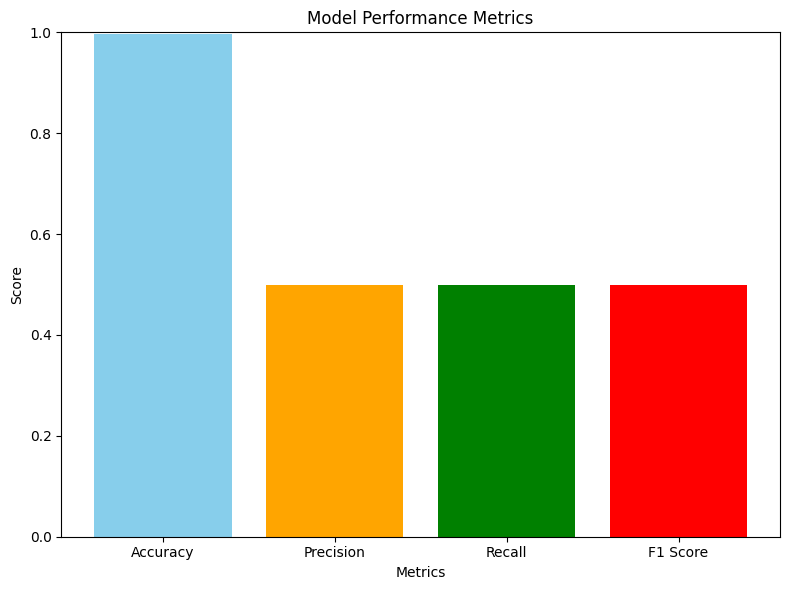

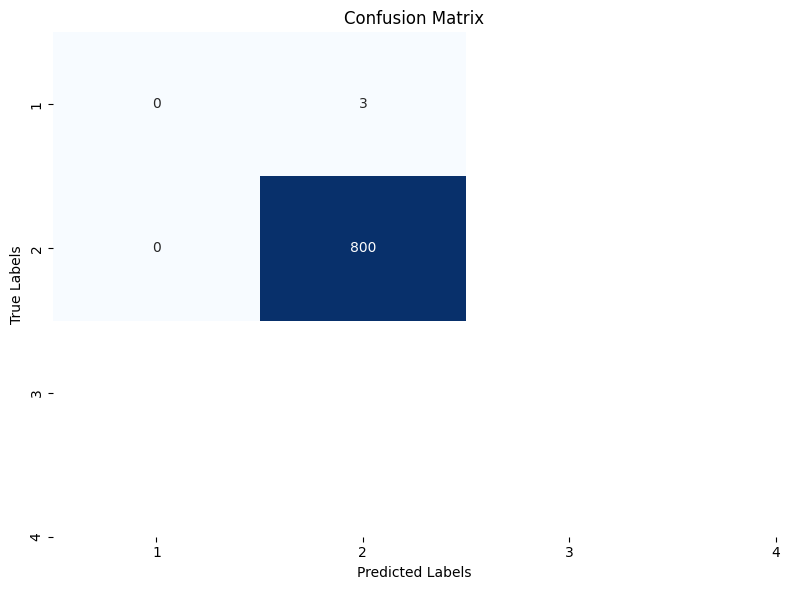

In [15]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

# Select a sample size that is less than or equal to the size of your dataset
sample_size = min(1000, len(train_x))  # Ensure sample_size <= len(train_x)

# Select random images from the dataset
random_indices = random.sample(range(len(train_x)), sample_size)
test_x = train_x[random_indices]
test_y = train_y[random_indices]

# Run predictions
predictions = model.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_y, predicted_classes)
recall = recall_score(test_y, predicted_classes, average='macro')
precision = precision_score(test_y, predicted_classes, average='macro')
f1 = f1_score(test_y, predicted_classes, average='macro')
conf_matrix = confusion_matrix(test_y, predicted_classes)

# Print Classification Report for reference
print("\nClassification Report:\n", classification_report(test_y, predicted_classes))

# Create a bar plot for accuracy, precision, recall, and F1 score
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

# Create a figure and axis for the bar plot
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Ensure y-axis goes from 0 to 1 for better comparison
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

<ipython-input-16-c443f046a258>:17: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


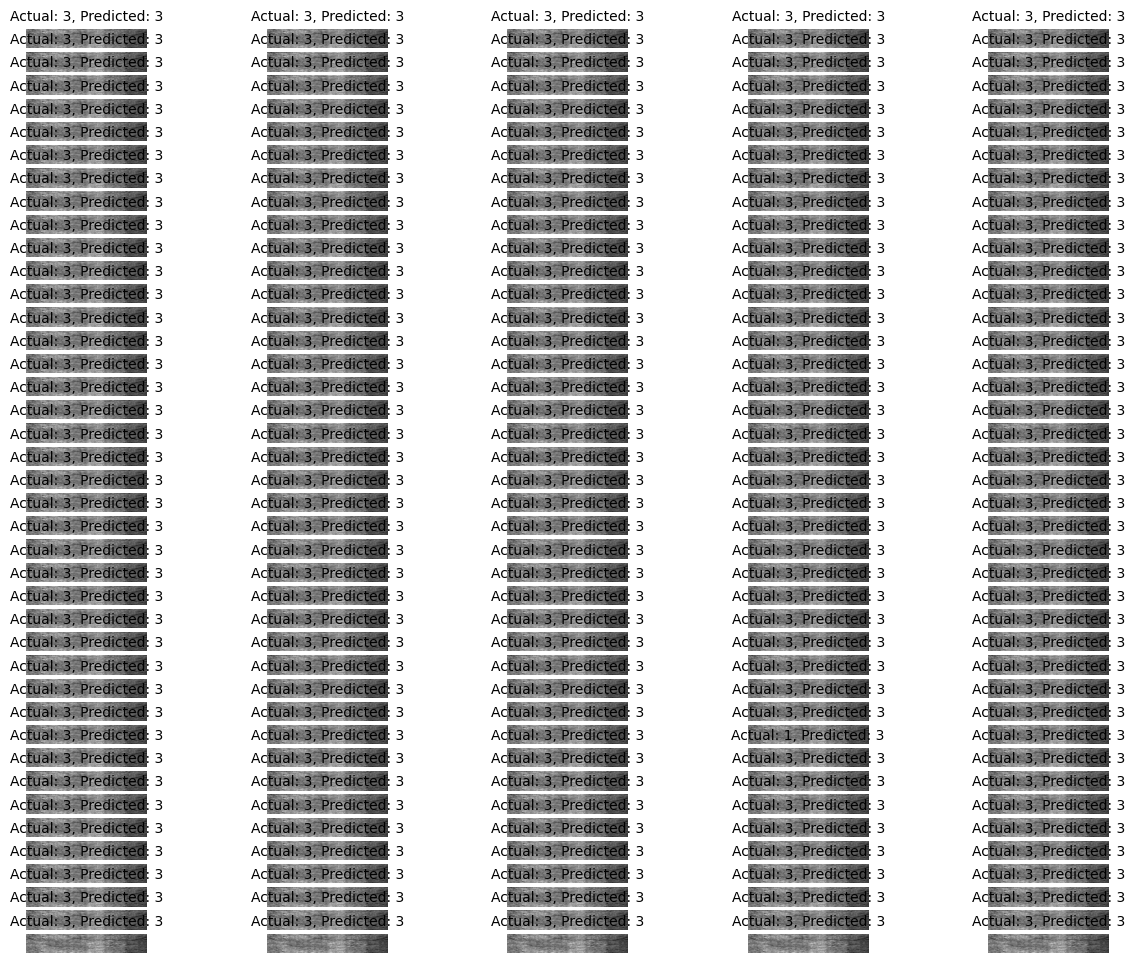

In [16]:
import matplotlib.pyplot as plt

# Plot a table of images, actual grades, and predicted grades
def plot_images_with_labels(images, actual_labels, predicted_labels, rows=4, cols=5):
    fig, axs = plt.subplots(rows, cols, figsize=(15, 12))

    for i in range(rows * cols):
        ax = axs[i // cols, i % cols]

        # Display the image
        ax.imshow(images[i].reshape(100, 625), cmap='gray')

        # Title shows actual vs predicted grades
        ax.set_title(f'Actual: {actual_labels[i]+1}, Predicted: {predicted_labels[i]+1}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display 20 random images with actual and predicted grades
plot_images_with_labels(test_x, test_y, predicted_classes, rows=40, cols=5)


<ipython-input-17-69e0119f0a85>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette='viridis')


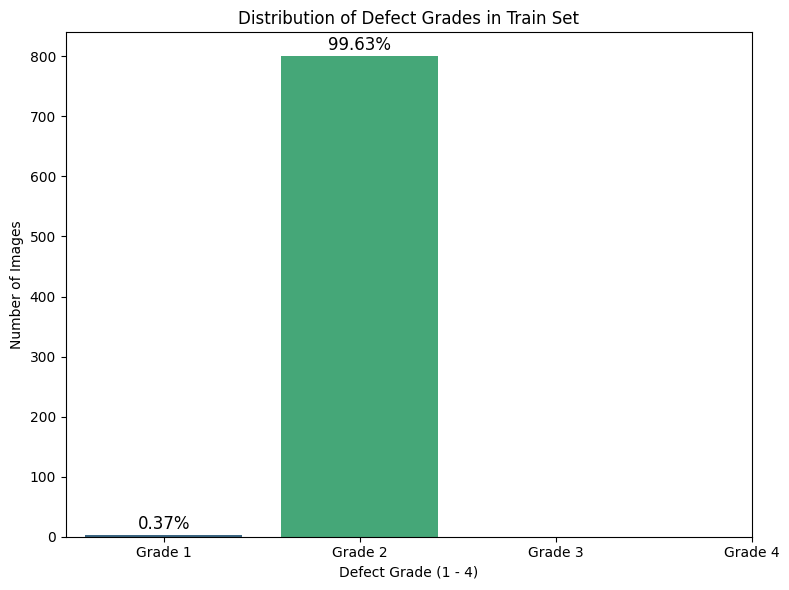

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the percentage of each grade in train_y
unique, counts = np.unique(train_y, return_counts=True)
percentages = (counts / len(train_y)) * 100

# Create a plot to visualize the distribution of train_y values
plt.figure(figsize=(8, 6))

# Plot the distribution of grades
sns.barplot(x=unique, y=counts, palette='viridis')

# Add labels and title
plt.title('Distribution of Defect Grades in Train Set')
plt.xlabel('Defect Grade (1 - 4)')
plt.ylabel('Number of Images')
plt.xticks([0, 1, 2, 3], ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4'])

# Annotate each bar with the percentage
for i in range(len(unique)):
    plt.text(i, counts[i] + 10, f'{percentages[i]:.2f}%', ha='center', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [18]:
model.save('cnn_model.h5')
